# load package

In [1]:
from glob import glob
from skimage.io import imread
from os import listdir

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

**How many patients do we have?**

In [3]:
base_path = "../input/breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

**How many patches do we have in total?** 


Our algorithm needs to decide whether an image patch contains IDC or not. Consequently not the whole patient tissue slice but the single patches have to be considered as input to our algorithm. How many of them do we have in total?

In [4]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)


In [5]:
total_images

277524

Ok, roughly 280000 images. To feed the algorithm with image patches it would be nice to store the path of each image. This way we can load batches of images only one by one without storing the pixel values of all images.

**Storing the image_path, patient_id and the target** 

In [6]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

patient_id                                               path target
0      10295  ../input/breast-histopathology-images/IDC_regu...      0
1      10295  ../input/breast-histopathology-images/IDC_regu...      0
2      10295  ../input/breast-histopathology-images/IDC_regu...      0
3      10295  ../input/breast-histopathology-images/IDC_regu...      0
4      10295  ../input/breast-histopathology-images/IDC_regu...      0

Ok, now for each patient we know the path for each patch as well as if it contains IDC or not (the target).

In [7]:
data.shape

(277524, 3)

# Exploratory analysis

## What do we know about our data?

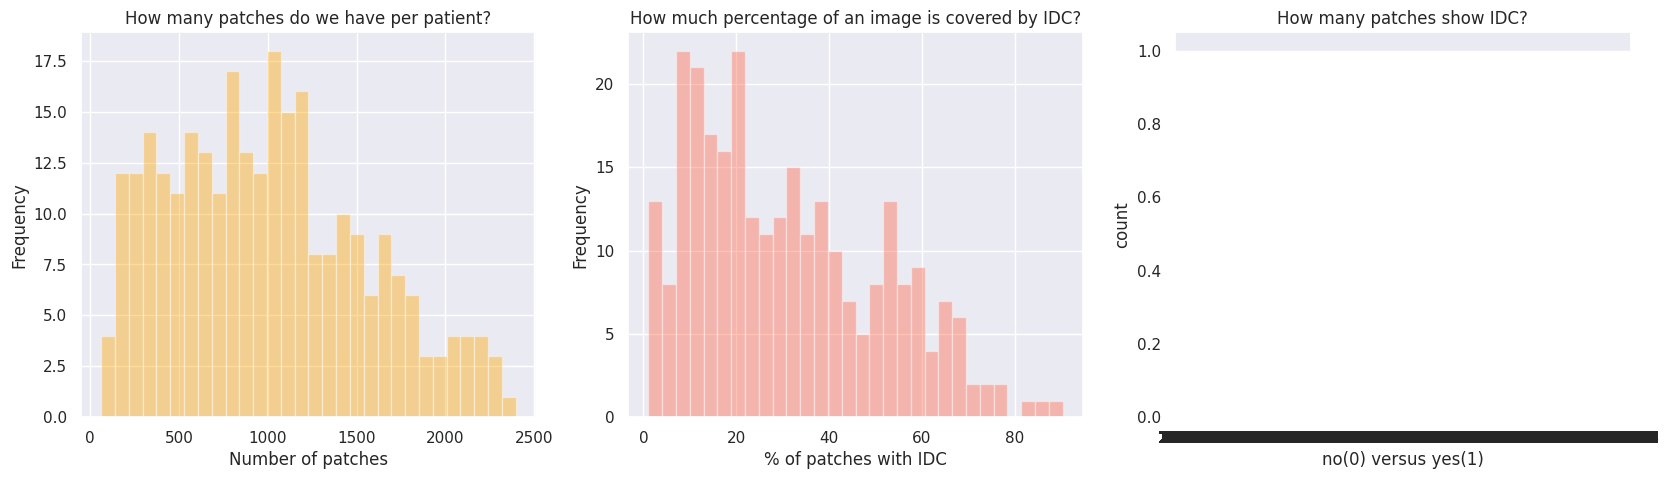

In [8]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

**Insights**
1. The number of image patches per patient varies a lot! This leads to the questions whether all images show the same resolution of tissue cells of if this varies between patients.
2. Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer. Does a tissue slice per patient cover the whole region of interest?
3. The classes of IDC versus no IDC are imbalanced. We have to check this again after setting up a validation strategy and find a strategy to deal with class weights (if we like to apply them).

### Looking at healthy and cancer patches 

In [9]:
data.target = data.target.astype(int)

In [10]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

### Cancer patches

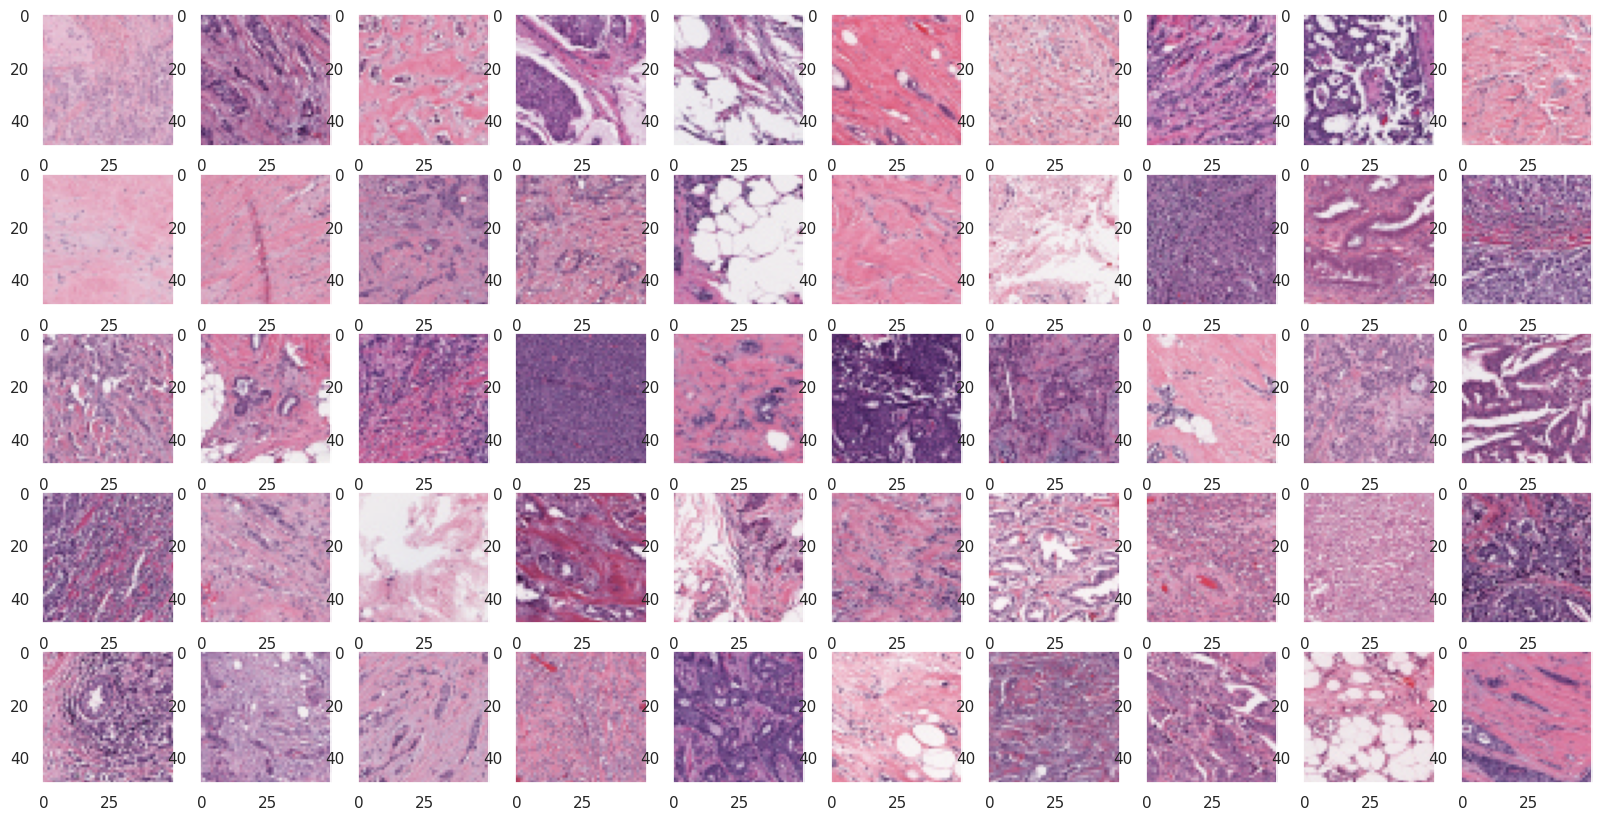

In [11]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

## Healthy patches

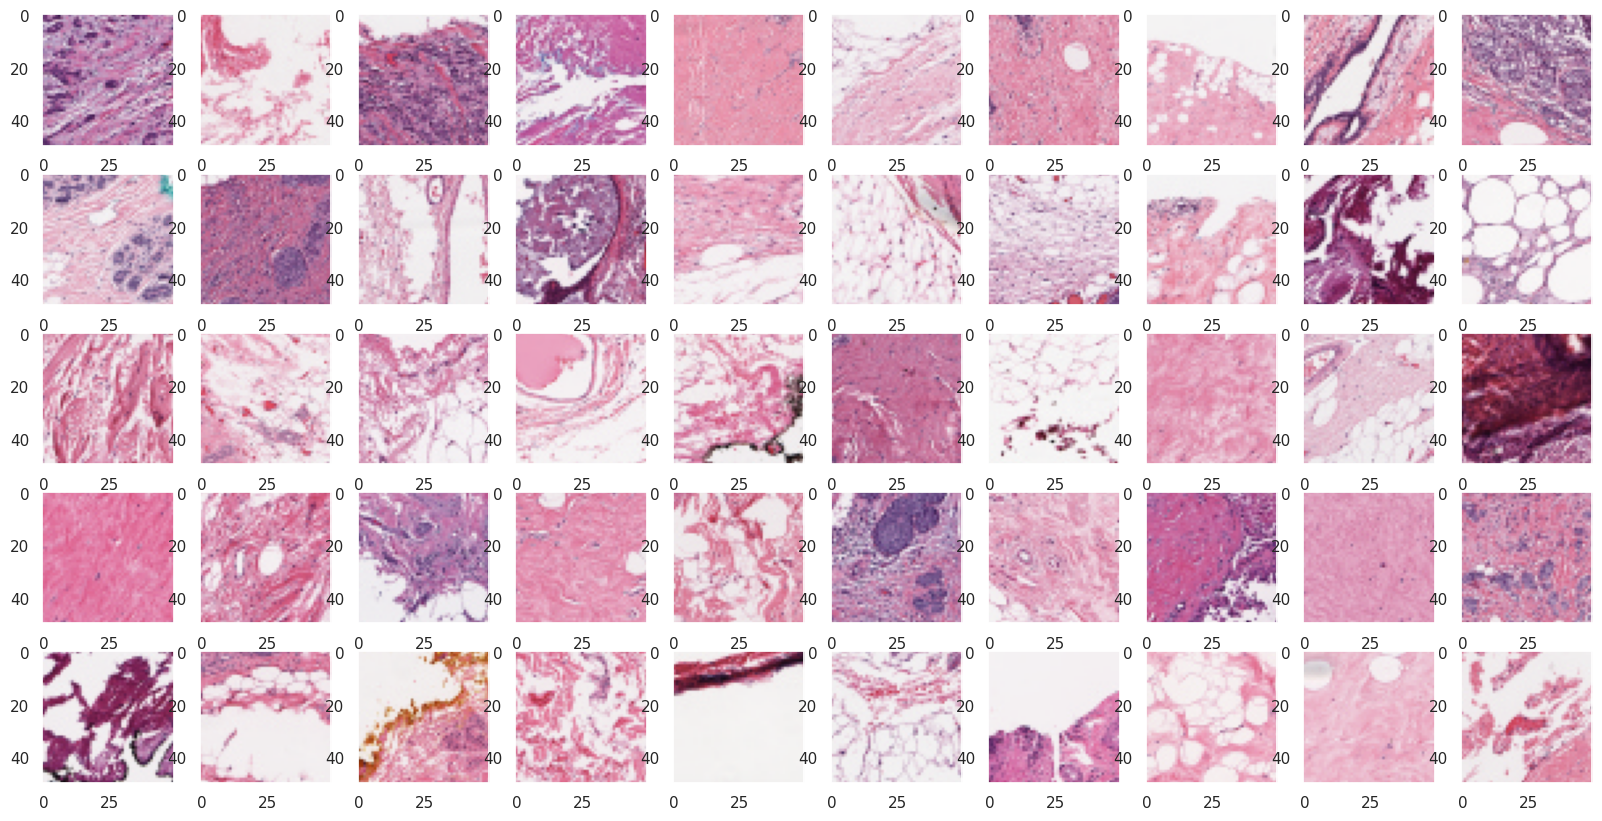

In [12]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

**Insights**
* Sometimes we can find artifacts or incomplete patches that have smaller size than 50x50 pixels.
* Patches with cancer look more violet and crowded than healthy ones. Is this really typical for cancer or is it more typical for ductal cells and tissue?
* Though some of the healthy patches are very violet colored too!
* Would be very interesting to hear what criteria are important for a pathologist.
* I assume that the wholes in the tissue belong to the mammary ducts where the milk can flow through.

### Visualising the breast tissue 
This part is a bit tricky! We have to extract all coordinates of image patches that are stored in the image names. Then we can use the coordinates to reconstruct the whole breast tissue of a patient. This way we can also explore how diseased tissue looks like compared to healthy ones. To simplify this task let's write a method that takes a patient and outcomes a dataframe with coordinates and targets.

In [13]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1] , axis = 0)
    return patient_df

In [14]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x     y  target                                               path
0  1351  1101       0  ../input/breast-histopathology-images/IDC_regu...
1  1501   501       0  ../input/breast-histopathology-images/IDC_regu...
2  1501  1101       0  ../input/breast-histopathology-images/IDC_regu...
3   451   901       0  ../input/breast-histopathology-images/IDC_regu...
4   801   451       0  ../input/breast-histopathology-images/IDC_regu...

Ok, now we have the coordinates for each patch, its path to load the image and its target information.

**Binary target visualisation per tissue slice**

Before we will take a look at the whole tissue let's keep it a bit simpler by looking at the target structure in the x-y-space for a handful of patients:

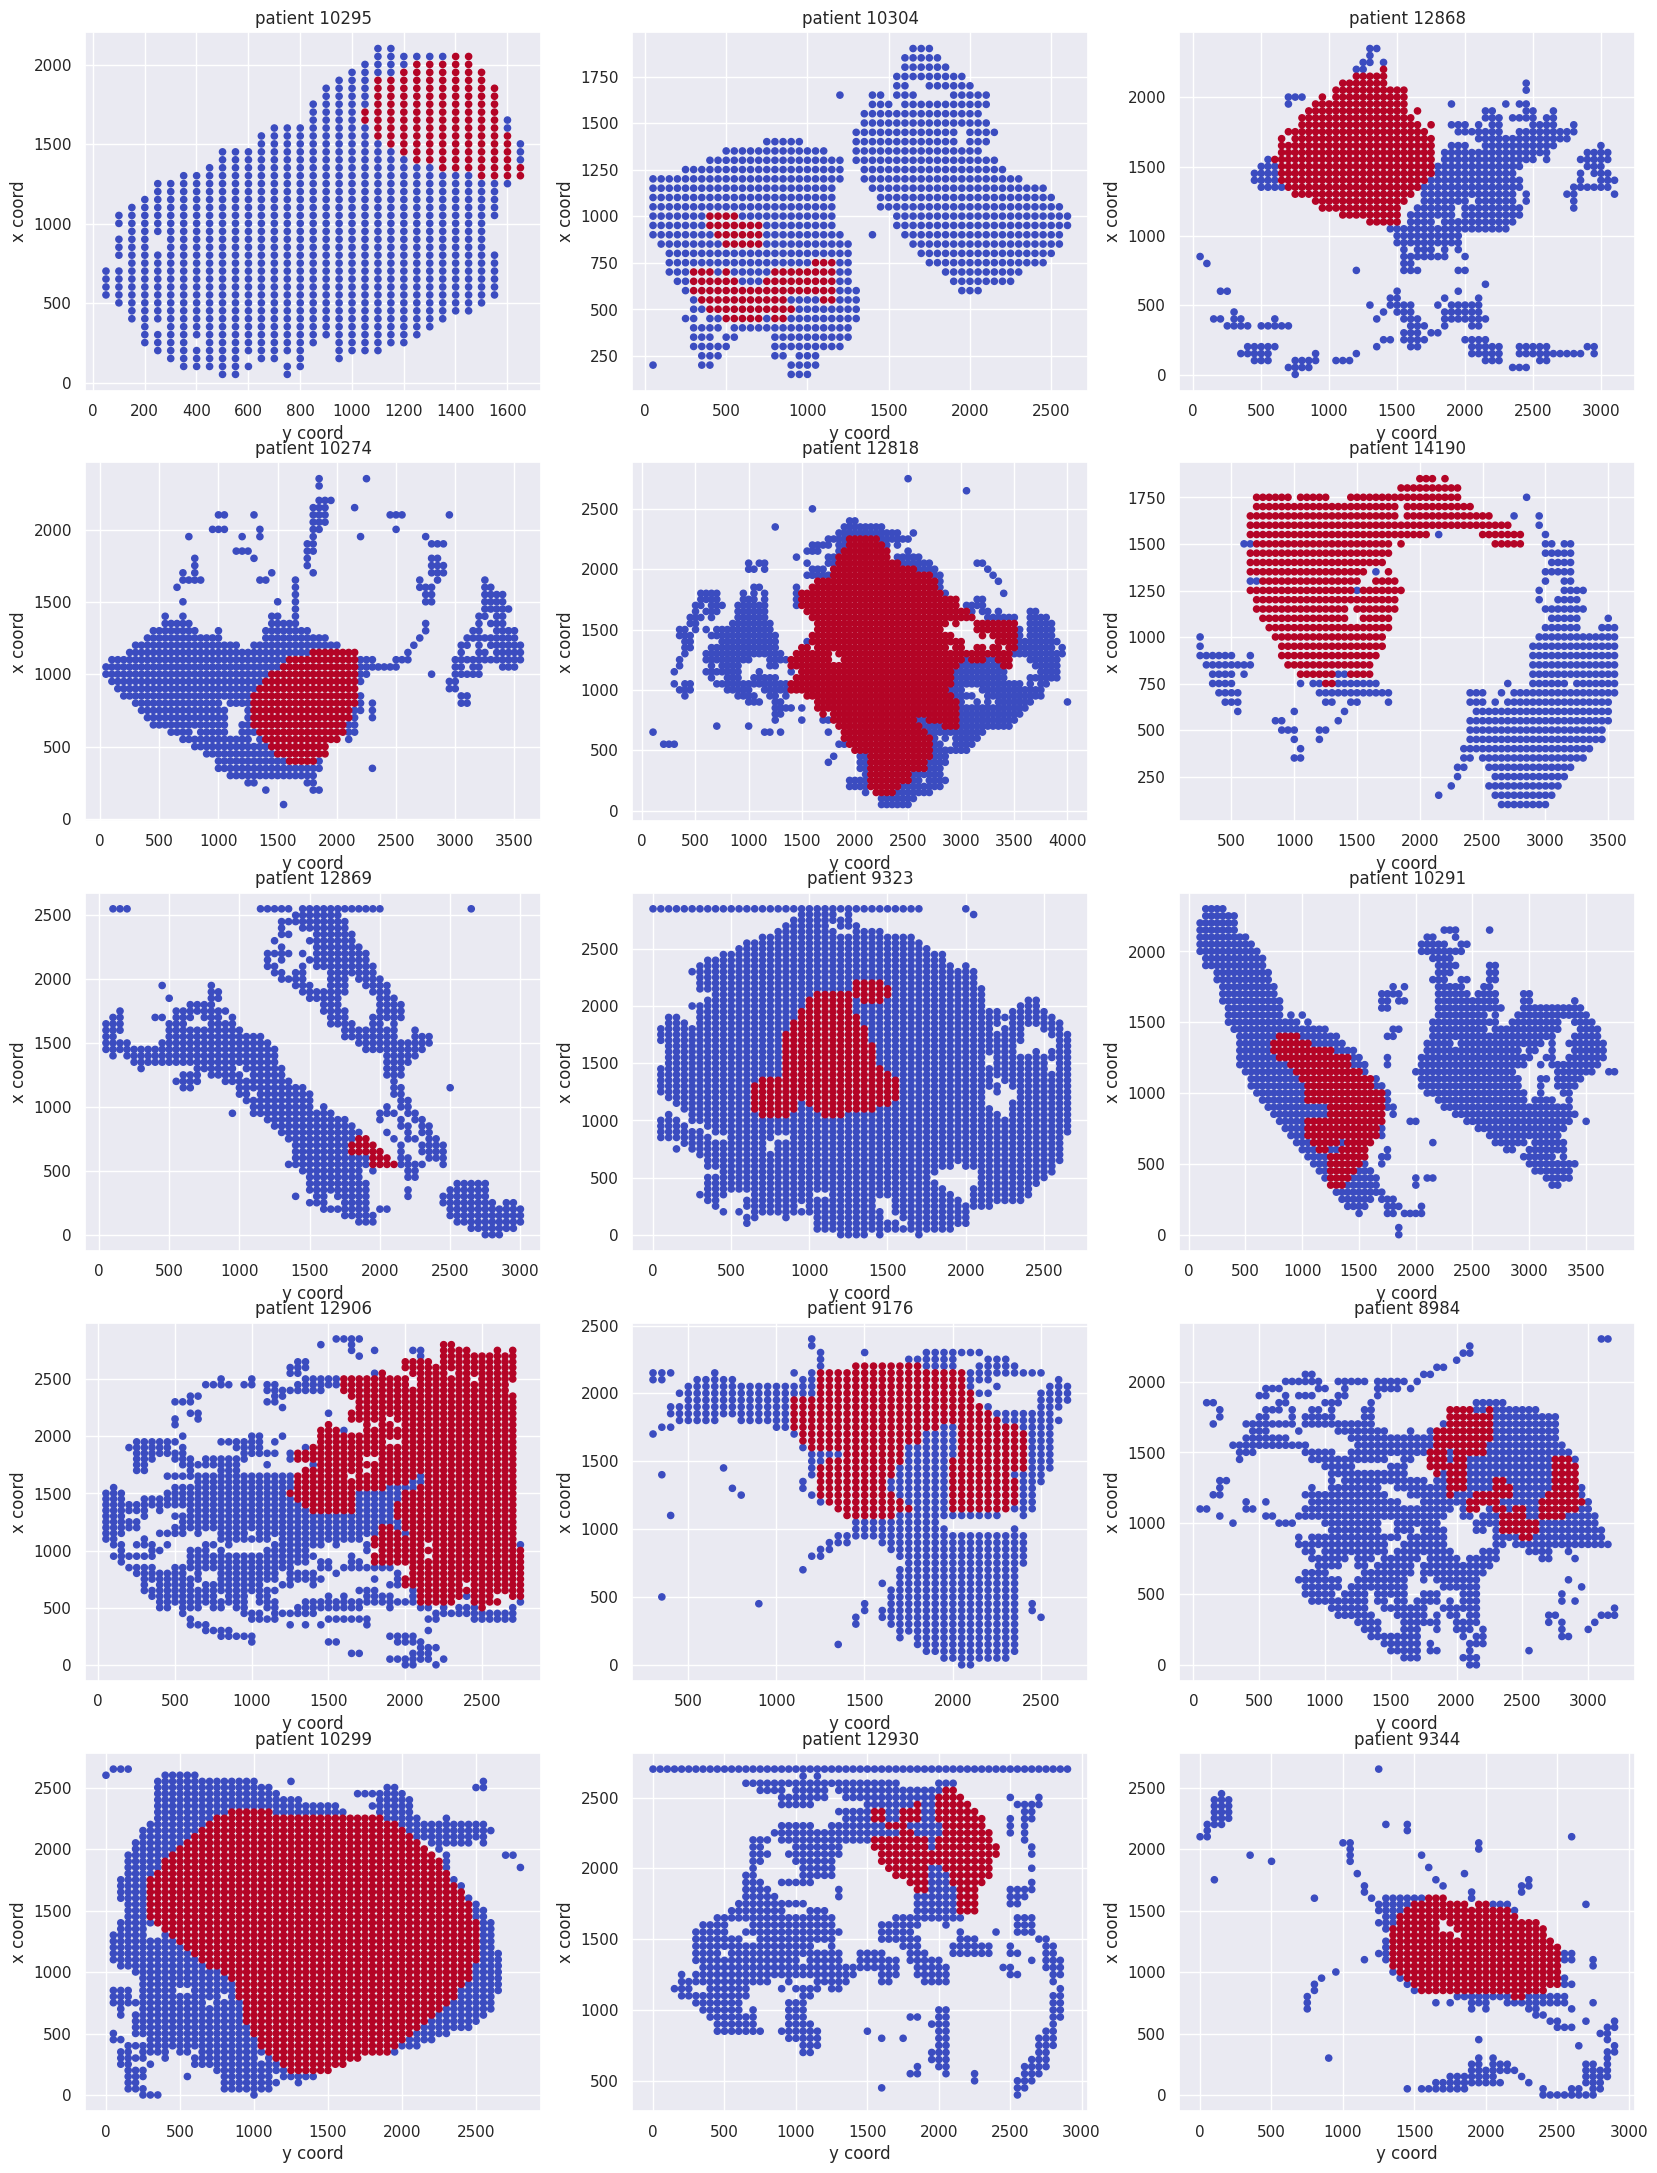

In [15]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

Insights
* Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation.
* Reading the paper (link!) that seems to be related to this data this could also be part of the preprocessing.

**Visualising the breast tissue images**

Ok, now it's time to go one step deeper with our EDA. Given the coordinates of image patches we could try to reconstruct the whole tissue image (not only the targets).

In [16]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

Let's use an example patient with id 13616:

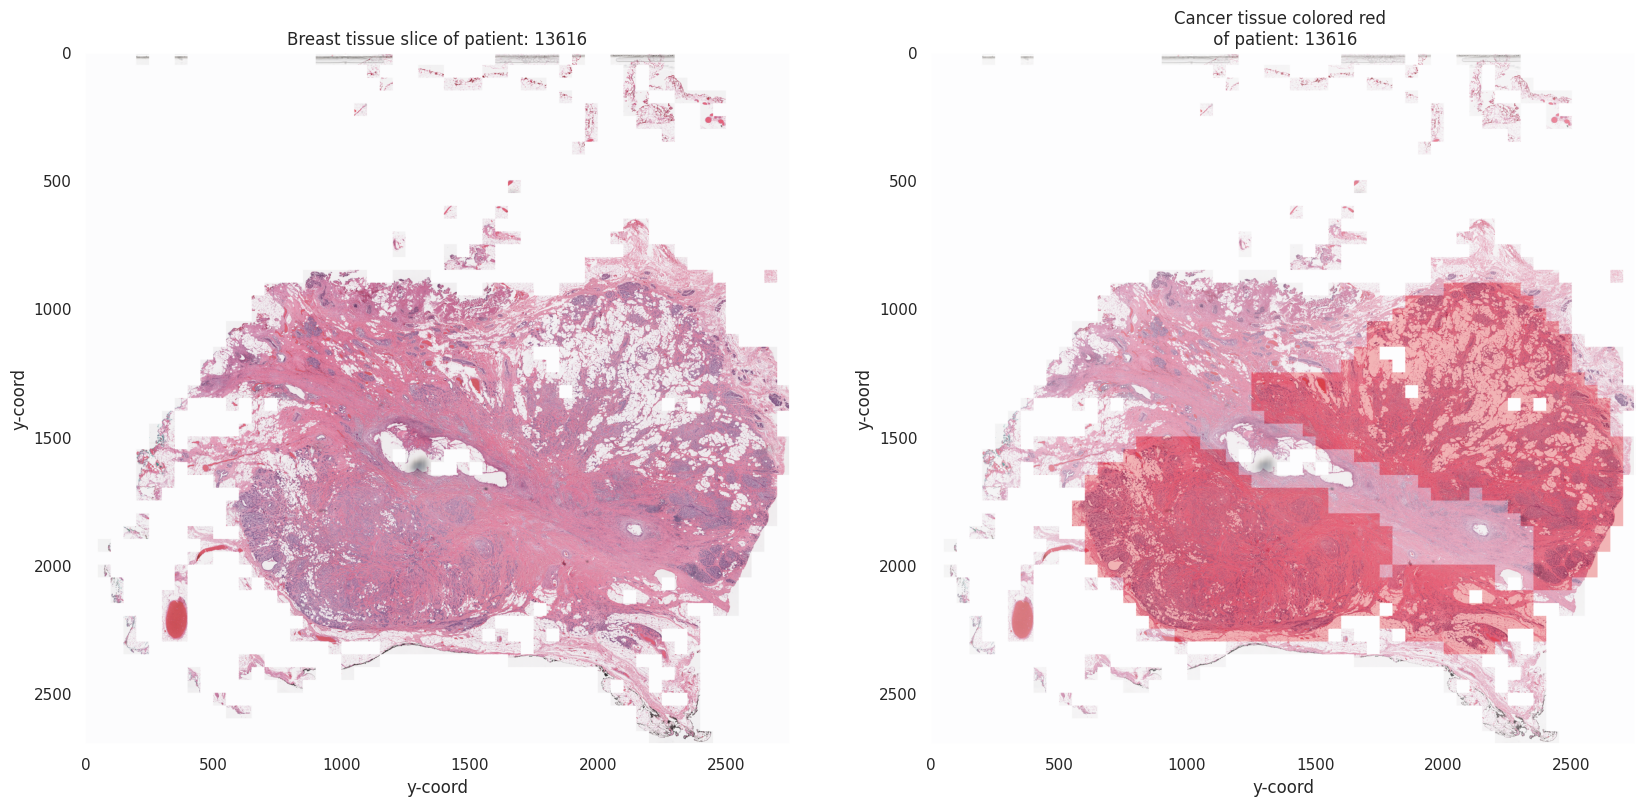

In [17]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + example)
ax[1].set_title("Cancer tissue colored red \n of patient: " + example);

## Preprocessing